# Trabajo Computacional 3 - Sistemas Complejos 2018

In [1]:
# Importacion de librerias #
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats
import community
#import infomap
import igraph
import pandas as pd
from io import StringIO

Cargamos los datos

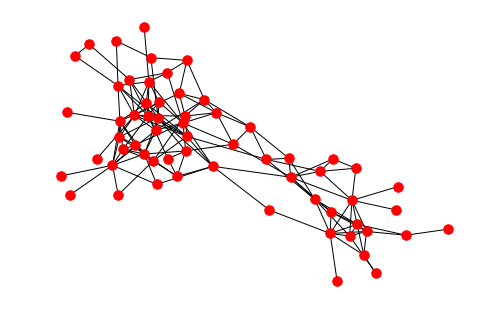

In [2]:
G=nx.read_gml('dolphins.gml')
nx.draw(G, with_labels=False, font_weight='bold',node_size=90)
plt.show()

Le agregamos el género a los delfines

In [3]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

data_gender=ldata('dolphinsGender.txt')
data_gender
colores=[]

# Le agregamos el atributo "genero" al grafo G
for elemento in data_gender:
    G.node[elemento[0]]['genero']=elemento[1]
    
# Creamos un vector de colores que vincula los generos (mismo orden)     
for node in G.node:
    gen = G.node[node]['genero']
    #print(node,gen)
    if gen=='f':
        colores.append('red')
    elif gen=='m':
        colores.append('blue')
    else:
        colores.append('grey')

Graficamos el grafo

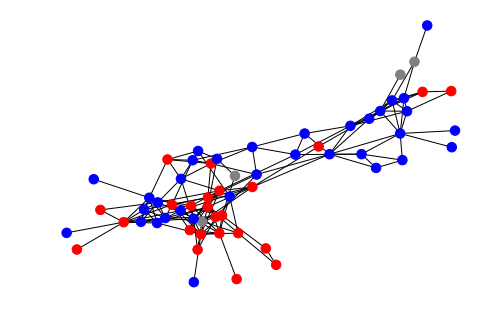

In [4]:
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_grouping='genero',node_size=90)
plt.show()

# Funcion que calcula particiones

In [5]:
def clusterize(nx_Graph, method="infomap"):
    """
    Calcula el agrupamiento en comunidades de un grafo.
    
    In:
        nx_Graph: grafo de networkx
        method: metodo de clustering, puede ser: "infomap", "fastgreedy", "eigenvector", "louvain", "edge_betweenness","label_prop", "walktrap", ""
        
    Out:
        labels_dict: diccionario de nodo : a label al cluster al que pertenece.
    """
    if method == "edge_betweenness":
        nx_Graph = max(nx.connected_component_subgraphs(nx_Graph), key=len)#se queda con la componente más grande.
        print("AVISO: restringiendo a la componente connexa más grade. De otro modo falla el algoritmo de detección de comunidades edge_betweenness.")
    
    isdirected = nx.is_directed(nx_Graph)
    np_adj_list = nx.to_numpy_matrix(nx_Graph)
    g = igraph.Graph.Weighted_Adjacency(np_adj_list.tolist(),mode=igraph.ADJ_UPPER)
   
    if method=="infomap":
        labels = g.community_infomap(edge_weights="weight").membership
    if method=="label_prop":
        labels = g.community_label_propagation(weights="weight").membership
    if method=="fastgreedy":
        labels = g.community_fastgreedy(weights="weight").as_clustering().membership
    if method=="eigenvector":
        labels = g.community_leading_eigenvector(weights="weight").membership
    if method=="louvain":
        labels = g.community_multilevel(weights="weight").membership
    if method=="edge_betweenness":
        labels = g.community_edge_betweenness(weights="weight", directed=isdirected).as_clustering().membership
    if method=="walktrap":
        labels = g.community_walktrap(weights="weight").as_clustering().membership
    
    label_dict = {node:label for node,label in zip(nx_Graph.nodes(), labels)}
    return label_dict

In [6]:
colors = ['red','blue','yellow','grey','orange','violet','green']

Creamos una función para graficar las redes

In [7]:
def draw_partitions(partition):
    #drawing
    plt.figure(1,figsize=(10,10)) 
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 130,
                                    node_color = colors[int(count)]) 

    nx.draw_networkx_edges(G, pos, alpha=0.2,labels=True)
    plt.axis('off')

    plt.show()

# Clustering por Louvain

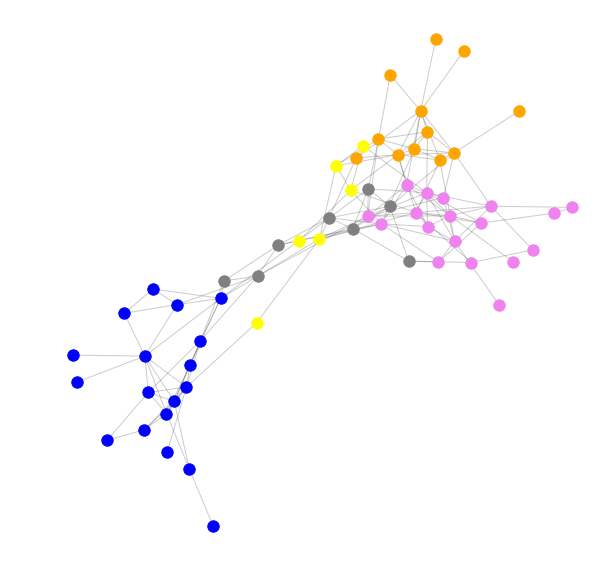

In [8]:
partition_louvain = clusterize(G, method="louvain")
draw_partitions(partition_louvain)

# Clustering por Edge Betweenness

In [9]:
partition_edge_betweennes = clusterize(G, method="edge_betweenness")

AVISO: restringiendo a la componente connexa más grade. De otro modo falla el algoritmo de detección de comunidades edge_betweenness.


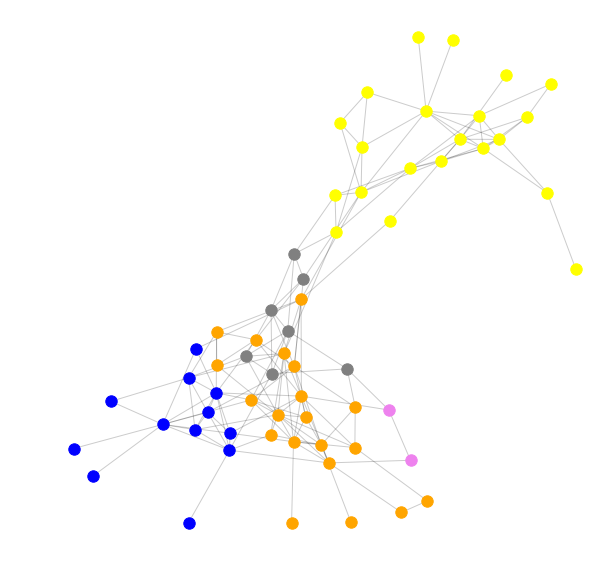

In [10]:
draw_partitions(partition_edge_betweennes)

# Clustering por Fast Greedy

In [11]:
partition_fast_greedy = clusterize(G, method="fastgreedy")

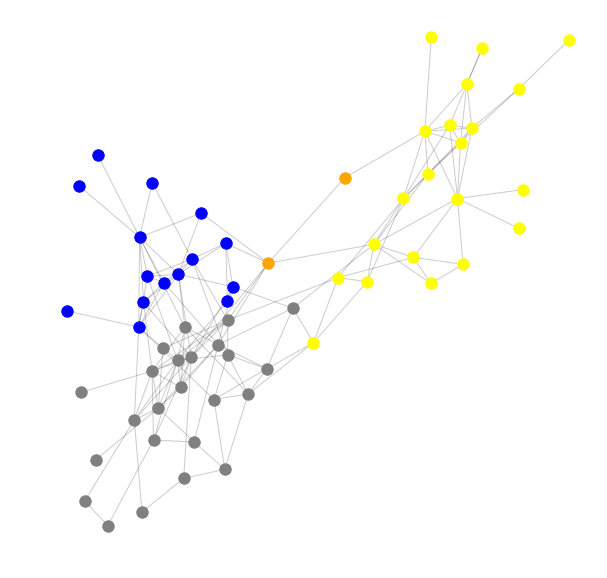

In [12]:
draw_partitions(partition_fast_greedy)

# Clustering por Infomap

In [13]:
partition_infomap = clusterize(G, method="infomap")

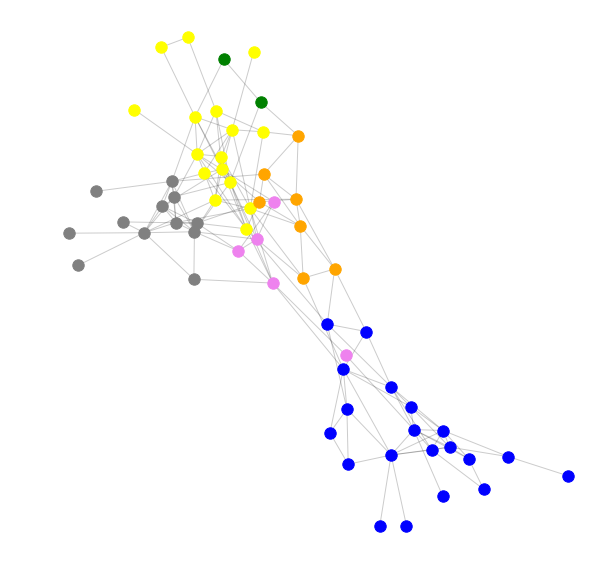

In [14]:
draw_partitions(partition_infomap)

Analizamos la cantidad de nodos en cada comunidad y 

In [16]:
def analisis_comunidades(G,partition):
    l = len(G)
    i = 0
    comunidades = 0
    while i < l:
        nombre_nodo_i = list(G)[i]
        comunidad_nodo_i = partition[nombre_nodo_i]
        if comunidad_nodo_i > comunidades:
            comunidades = comunidad_nodo_i
        i+=1
    
    i = 0
    nodos_comunidades= np.zeros(comunidades+1)
    while i < l:
        nombre_nodo_i = list(G)[i]
        comunidad_nodo_i = partition[nombre_nodo_i]
        nodos_comunidades[comunidad_nodo_i] += 1
        i+=1
        
    return (comunidades,nodos_comunidades)

In [17]:
def Silhouette_Coefficient(G,partition):
    l = len(G)
    i = 0
    comunidades = analisis_comunidades(G,partition)[0]
    nodos_comunidades = analisis_comunidades(G,partition)[1]
    s = []
    
    while i < l:
        nombre_nodo_i = list(G)[i]
        camino_comunidad= np.zeros(comunidades+1)
        comunidad_nodo_i = partition[nombre_nodo_i]
        distancia_i_comunidad = []
        j = 0
        while j < l:
            nombre_nodo_j = list(G)[j]
            comunidad_nodo_j = partition[nombre_nodo_j]
            camino = nx.shortest_path_length(G,source=nombre_nodo_i,target=nombre_nodo_j)
            if comunidad_nodo_i == comunidad_nodo_j and i!=j:
                distancia_i_comunidad +=[camino] 
            else:
                camino_comunidad[comunidad_nodo_j] += camino
            
            j+=1
            
        distancia_cluster_propio = np.mean(distancia_i_comunidad)    
        distancia_clusters_vecinos = camino_comunidad/nodos_comunidades
        distancia_cluster_mas_cercano = np.min(distancia_clusters_vecinos[np.nonzero(distancia_clusters_vecinos)])
                        
            
        numerador = distancia_cluster_mas_cercano - distancia_cluster_propio
        denominador = np.maximum(distancia_cluster_mas_cercano,distancia_cluster_propio)
        s+=[numerador/float(denominador)]

        i+=1
    
    return s


In [18]:
Silhouette_Coefficient_edge_betweennes = np.max(Silhouette_Coefficient(G,partition_edge_betweennes))

In [19]:
Silhouette_Coefficient_fast_greedy = np.max(Silhouette_Coefficient(G,partition_fast_greedy))

In [20]:
Silhouette_Coefficient_infomap = np.max(Silhouette_Coefficient(G,partition_infomap))

In [21]:
Silhouette_Coefficient_louvain = np.max(Silhouette_Coefficient(G,partition_louvain))

In [22]:
data = pd.DataFrame({" ":["Edge Betweennes",'Fast Greedy','Infomap','Louvain'],
                     "Silhoutte":[round(Silhouette_Coefficient_edge_betweennes,2),round(Silhouette_Coefficient_fast_greedy,2),round(Silhouette_Coefficient_infomap,2),round(Silhouette_Coefficient_louvain,2)],
                     })
data

,,Silhoutte
0,Edge Betweennes,0.63
1,Fast Greedy,0.61
2,Infomap,0.61
3,Louvain,0.55
